In [54]:
from scipy.special import expit
from dotenv import load_dotenv
from openai import OpenAI
from typing import Any
from collections import Counter, defaultdict

from src.utils import data_to_storage, normalize_vector
from src.models import get_embedding
from src.faiss import build_faiss_hnsw_index, populate_faiss_index
from src.utils import preprocess
from src.tokenizer import enc
from src.chunkinizer import chunkinizer

import math
import re
import pandas as pd
import numpy as np
import pickle
import os

load_dotenv() 

EMBEDDER_API_KEY = os.getenv('EMBEDDER_API_KEY')
LLM_API_KEY = os.getenv('LLM_API_KEY')
OPENROUTER_API_KEY = os.getenv('OPENROUTER_API_KEY')

TEXT_EMBEDDINGS_DIMENSIONS = 1536
TEXT_CHUNK_SIZE = 425
TEXT_OVERLAP = 0.25

ANNOTATION_EMBEDDINGS_DIMENSIONS = 1536
TAGS_ANNOTATIONS_CHUNK_SIZE = 256
TAGS_ANNOTATIONS_OVERLAP = 0.3

BM25_KOEF = 0.15
EMBED_KA_KOEF = 0.15
EMBED_T_KOEF = 0.7

FAISS_ANNOTATION_K = 5 # Топ K при поиске в faiss
FAISS_TEXT_K = 12 # Топ K при поиске в faiss
BM25_TOPK = 8 # Top k для BM25
TOP_K = 12 # Топ K документов для RAG
KLLM = 5

BM25_WEIGHT = 0.2
FAISS_TEXT = 0.65
FAISS_TAGS_ANNOT = 0.15

In [28]:
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=OPENROUTER_API_KEY,
)

# 1. Подготовка Данных

In [40]:
# Тренировочный датасет
raw_data = pd.read_csv('train_data.csv')

raw_data.head()

,id,annotation,tags,text
0,doc_001,Светлана из Казани дает частные уроки английск...,"['Начать бизнес', 'Самозанятые', 'Свое дело', ...",## Кто такой самозанятый?\n\nПо закону самозан...
1,doc_002,"Елене назначили социальное пособие на ребенка,...","['Защитить права', 'Банки', 'Банковская карта'...",Первым делом нужно попросить банк проверить ма...
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"['Кредиты', 'Долги', 'Просрочки', 'Ипотека', '...",## Не переоценивайте свои финансовые возможнос...
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","['Инвестиции', 'Ценные бумаги', 'Фондовая бирж...",Просто прийти на биржу и купить ценные бумаги ...
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"['Займы', 'Долги', 'Риски', 'Защитить права']","## МФО больше нет в госреестре. Значит, она за..."


In [41]:
data = preprocess(raw_data)
data.head()

,id,annotation,tags,text
0,doc_001,Светлана из Казани дает частные уроки английск...,"Начать бизнес, Самозанятые, Свое дело, Налоги","[(Кто такой самозанятый?, По закону самозаняты..."
1,doc_002,"Елене назначили социальное пособие на ребенка,...","Защитить права, Банки, Банковская карта, Риски...","[(, Первым делом нужно попросить банк проверит..."
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"Кредиты, Долги, Просрочки, Ипотека, Кредитная ...","[(, Не переоценивайте свои финансовые возможно..."
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","Инвестиции, Ценные бумаги, Фондовая биржа, Акц...","[(, Просто прийти на биржу и купить ценные бум..."
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"Займы, Долги, Риски, Защитить права","[(МФО больше нет в госреестре. Значит, она зак..."


# 2. Чанкование

In [42]:
# Собираем чанки для тегов и аннотации
chunks_ta = [
    chunkinizer(
        vanila_chunkinizer = 1,
        text = f"{tags}. {annototions}", 
        chunk_size=TAGS_ANNOTATIONS_CHUNK_SIZE, 
        overlap_part=TAGS_ANNOTATIONS_OVERLAP
        ) 
        for annototions, tags in zip(data['annotation'], data['tags'])
    ]

data['annotation_tags_chunk'] = chunks_ta

In [43]:
# Собираем чанки для текста
chunks_t = list()

for row in data['text']:
    doc_chunks = list()
    for doc in row:
        question, answer = doc[0], doc[1]
        doc_chunks.append(chunkinizer(
            vanila_chunkinizer = 0,
            question=question, 
            answer=answer, 
            chunk_size=TEXT_CHUNK_SIZE, 
            overlap_part=TEXT_OVERLAP)
            )

    chunks_t.append(doc_chunks)

data['text_chunk'] = chunks_t

In [44]:
data.head()

,id,annotation,tags,text,annotation_tags_chunk,text_chunk
0,doc_001,Светлана из Казани дает частные уроки английск...,"Начать бизнес, Самозанятые, Свое дело, Налоги","[(Кто такой самозанятый?, По закону самозаняты...","[Начать бизнес, Самозанятые, Свое дело, Налоги...",[[Кто такой самозанятый?По закону самозанятый ...
1,doc_002,"Елене назначили социальное пособие на ребенка,...","Защитить права, Банки, Банковская карта, Риски...","[(, Первым делом нужно попросить банк проверит...","[Защитить права, Банки, Банковская карта, Риск...",[[Первым делом нужно попросить банк проверить ...
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"Кредиты, Долги, Просрочки, Ипотека, Кредитная ...","[(, Не переоценивайте свои финансовые возможно...","[Кредиты, Долги, Просрочки, Ипотека, Кредитная...",[[Не переоценивайте свои финансовые возможност...
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","Инвестиции, Ценные бумаги, Фондовая биржа, Акц...","[(, Просто прийти на биржу и купить ценные бум...","[Инвестиции, Ценные бумаги, Фондовая биржа, Ак...",[[Просто прийти на биржу и купить ценные бумаг...
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"Займы, Долги, Риски, Защитить права","[(МФО больше нет в госреестре. Значит, она зак...","[Займы, Долги, Риски, Защитить права. Вы взяли...","[[МФО больше нет в госреестре. Значит, она зак..."


# 3. Подготовка json БД

In [45]:
# Создаем JSON  DB в формате [Сквозной идентификатор : (doc_id, chunk)] для тегов и ннотаций
storage_an_t = data_to_storage(
        id_series = data['id'],
        data_series = data['annotation_tags_chunk']
    )

Storage ready, key from 0 to 366


In [46]:
# Создаем JSON  DB в формате [Сквозной идентификатор : (doc_id, chunk)] для текстовых чанков
storage_t = data_to_storage(
        id_series = data['id'],
        data_series = data['text_chunk']
    )

Storage ready, key from 0 to 4875


In [47]:
# Пример собранных данныъ
print(storage_t[0], storage_t[1], sep='\n')

('doc_001', 'Кто такой самозанятый?По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль. Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины. Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.')
('doc_001', 'Сколько составляет налог на профессиональный доход?Есть два вида ставок для самозанятых. Какая именно будет использоваться в вашем случае, зависит от того, кто покупает ваши товары или услуги: * 4% — если деньги пришли от физического лица; * 6% — если оплата поступила от юридического лица или индивидуального предпринимателя. Эти ставки не будут меняться до конца 2028 года. Ученики Светланы — это в основном взрослые люди, которые хотят подтянуть разговорный английский перед отпуском или командировкой. За урок она берет 1000 рублей. Если Свет

# 4. Получаем эмбединги

## 4.1 Для тегов + аннотация

In [62]:
# Соберем текст для батчевого запроса
texts = list()
for _, val in storage_an_t.items():
    texts.append(val[1])

len(texts)

367

In [63]:
# Запрос к openrouter
responce = get_embedding(text=texts, batch_embeddings=True)
embeddings_an_t = [item.embedding for item in responce.data]

with open('data/embeddings_ta_text-embedding-3-small.pickle', 'wb') as f:
    pickle.dump(embeddings_an_t, f)

# with open('data/embeddings_ta_final.pickle', 'rb') as f:
#      embeddings_an_t = pickle.load(f)

In [64]:
# Соберем временное хранилище векторов
embed_storage_an_t = dict()

for i in range(len(embeddings_an_t)):
    embed_storage_an_t[i] = np.array(embeddings_an_t[i], np.float32)

# Размерность полученных эмбедингов
len(embed_storage_an_t), embed_storage_an_t[0].shape[0]

(367, 1536)

## 2.2 Для текста

In [55]:
# Соберем текст для батчевого запроса
texts = list()
for _, val in storage_t.items():
    texts.append(val[1])

len(texts)

4876

In [61]:
# Запрос к openrouter
batch_size = 32
embeddings_t = []

for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    response = get_embedding(text=batch, batch_embeddings=True) # Запрос к openrouter

    batch_embeddings = [item.embedding for item in response.data]
    embeddings_t.extend(batch_embeddings)
   
with open('data/embeddings_t_text-embedding-3-small.pickle', 'wb') as f:
    pickle.dump(embeddings_t, f)

# with open('data/embeddings_t_text-embedding-3-small.pickle', 'rb') as f:
#     embeddings_t = pickle.load(f)

In [67]:
# Соберем временное хранилище векторов
embed_storage_t = dict()

for i in range(len(embeddings_t)):
    embed_storage_t[i] = np.array(embeddings_t[i], np.float32)

# Размерность полученных эмбедингов
len(embed_storage_t), embed_storage_t[0].shape[0]

(4876, 1536)

# 5. Инициализируем Faiss

## 5.1 Для тегов + аннотация

In [68]:
# Define the dimensions of the embedding vectors
embedding_dimension = ANNOTATION_EMBEDDINGS_DIMENSIONS  # Depends on the FastText model ANNOTATION_EMBEDDINGS_DIMENSIONS = 512
# Build the HNSW index
hnsw_index_an_t = build_faiss_hnsw_index(embedding_dimension)
# Populate the index from pd.Series
populate_faiss_index(index=hnsw_index_an_t, documents=embed_storage_an_t)

# Define the dimensions of the embedding vectors
embedding_dimension = TEXT_EMBEDDINGS_DIMENSIONS  # Depends on the FastText model
# Build the HNSW index
hnsw_index_t = build_faiss_hnsw_index(embedding_dimension)
# Populate the index from pd.Series
populate_faiss_index(index=hnsw_index_t, documents=embed_storage_t)

In [69]:
# Тестовый поиск по annotation
correct_id = 2 # рандомный идентификатор для примера annotation 
example = get_embedding(text=data.loc[correct_id, 'annotation']) # По тексту annotation получаем эмбединг
example = normalize_vector(example)

top_k_indices, top_k_similarities = hnsw_index_an_t.search(np.array([example], dtype=np.float32), 1) # В БД Tags+annotation ищем пример

assert correct_id == top_k_similarities.item(), 'Что то не работает =('

print(f"Требуемый документ из   БД:  {storage_an_t[correct_id][0]} ")
print(f"Загруженный документ из БД:  {storage_an_t[top_k_similarities.item()][0]} ")

Требуемый документ из   БД:  doc_003 
Загруженный документ из БД:  doc_003 


In [72]:
# Тестовый поиск по tags
correct_id = 2 # рандомный идентификатор для примера annotation 
example = get_embedding(text=data.loc[correct_id, 'tags']) # По тексту tags получаем эмбединг
example = normalize_vector(example)

top_k_indices, top_k_similarities = hnsw_index_an_t.search(np.array([example], dtype=np.float32), 10) # В БД Tags+annotation ищем пример

if not correct_id == top_k_similarities[0][0]:
    for i, el in enumerate(top_k_similarities[0]):   
        if el.item() == correct_id:
            print(f'Только на позиции {i}')
            break

print(f"Требуемый документ из БД:    {storage_an_t[correct_id][0]} ")
print(f"Загруженный документ из БД:  {storage_an_t[top_k_similarities[0][0]][0]} ")

Только на позиции 5
Требуемый документ из БД:    doc_003 
Загруженный документ из БД:  doc_061 


In [357]:
# Тестовый поиск по annotation
correct_id = 10 # рандомный идентификатор для примера annotation 
print(f'Тестовая анотация на основе которой составлен вопрос: {data.loc[correct_id, "annotation"]}')
query = 'Я попал в автомобильную аварию - что мне делать?'
example = get_embedding(query) 
example = normalize_vector(example)


top_k_indices, top_k_similarities = hnsw_index_an_t.search(np.array([example], dtype=np.float32), 1) # В БД Tags+annotation ищем пример

assert correct_id == top_k_similarities.item(), 'Что то не работает =('

print(f"Требуемый документ из БД:    {storage_an_t[correct_id][0]} ")
print(f"Загруженный документ из БД:  {storage_an_t[top_k_similarities.item()][0]} ")

Тестовая анотация на основе которой составлен вопрос: Вы попали в небольшую аварию? Все живы-здоровы, а автомобили повреждены не очень сильно? Не нужно ждать сотрудников полиции, чтобы оформить происшествие. Вместе со вторым водителем вы можете сами задокументировать ДТП, чтобы пострадавший получил страховую выплату. Такая упрощенная процедура называется системой европротокола.
Требуемый документ из БД:    doc_011 
Загруженный документ из БД:  doc_011 


In [358]:
# Тестовый поиск по annotation
correct_id = 50 # рандомный идентификатор для примера annotation 
print(f'Тестовая анотация на основе которой составлен вопрос: {data.loc[correct_id, "annotation"]}')
query = 'Я внес платеж по кредиту вовремя, но банк мне прислали уведомдение о просрочке - почему?'
example = get_embedding(query) 
example = normalize_vector(example)

top_k_indices, top_k_similarities = hnsw_index_an_t.search(np.array([example], dtype=np.float32), 10) # В БД Tags+annotation ищем пример

if not correct_id == top_k_similarities[0][0]:
    for i, el in enumerate(top_k_similarities[0]):   
        if el.item() == correct_id:
            print(f'Только на позиции {i}')
            break

print(f"Требуемый документ из БД:    {storage_an_t[correct_id][0]} ")
print(f"Загруженный документ из БД:  {storage_an_t[top_k_similarities[0][0]][0]} ")

Тестовая анотация на основе которой составлен вопрос: Альбина гасит кредит через терминал для приема платежей. В этот раз она, как обычно, внесла деньги заранее, но банк прислал уведомление о просрочке. Оказалось, что банк, через который проходили платежи,лишился лицензиии деньги зависли. Разбираемся, почему так произошло и как действовать в подобной ситуации.
Только на позиции 6
Требуемый документ из БД:    doc_050 
Загруженный документ из БД:  doc_101 


## 5.2 Для текста

In [73]:
# Define the dimensions of the embedding vectors
embedding_dimension = TEXT_EMBEDDINGS_DIMENSIONS  # Depends on the FastText model

# Build the HNSW index
hnsw_index_t = build_faiss_hnsw_index(embedding_dimension)

# Populate the index from pd.Series
populate_faiss_index(index=hnsw_index_t, documents=embed_storage_t)

In [74]:
# Пример вопроса и ответа, по которому будем тестировать подход
data.loc[3, 'text'][2]

('В чем плюсы и минусы доверительного управления?',
 'Перед тем как обращаться к управляющему или покупать паи ПИФов, важно взвесить все за и против. **Плюсы** * Доверительное управление может принести больше дохода, чем банковский вклад. * Как и в случае с вкладом, вам не нужно постоянно следить за ситуацией на бирже, выбирать ценные бумаги или другие активы, определяться, когда их покупать, а когда продавать. Все решения за вас принимает доверительный управляющий или УК паевого фонда. **Минусы** * Прибыль не гарантирована. Инвестиции — это всегда риск, и чем больше потенциальная доходность, тем выше вероятность все потерять. Деньги в доверительном управлении не защищены государственной системой страхования вкладов. * Ваши доходы будут зависеть от решений посредника, выигрышных или неудачных. Поэтому выбирать доверительного управляющего или ПИФ стоит очень тщательно. Подробнее о рисках, с которыми сталкивается новичок на фондовом рынке, читайте в статье «Что нужно знать начинающему ин

In [75]:
# Тестовый поиск по ответу
correct_id = 3 # рандомный идентификатор 
user_query = data.loc[correct_id, 'text'][2][0] # [номер чанка][вопрос, ответ] - выбираем вопрос
print(f'User query: {user_query}')

example = get_embedding(text=user_query) 
example = normalize_vector(example)

top_k_indices, top_k_similarities = hnsw_index_t.search(np.array([example], dtype=np.float32), 10) # Ищем пример

if not correct_id == top_k_similarities[0][0]:
    for i, el in enumerate(top_k_similarities[0]):   
        if el.item() == correct_id:
            print(f'Только на позиции {i}')
            break
        
print(f"Требуемый документ из БД:    {data.loc[correct_id, 'id']} ")
print(f"Загруженный документ из БД:  {storage_t[top_k_similarities[0][0]][0]} ")

User query: В чем плюсы и минусы доверительного управления?
Требуемый документ из БД:    doc_004 
Загруженный документ из БД:  doc_004 


In [182]:
# Тестовый поиск
correct_id = 3 # рандомный идентификатор 
user_query = data.loc[correct_id, 'text'][2][1] # [номер чанка][вопрос, ответ] - выбираем ответ
example = get_embedding(text=user_query, dimensions=1024) 
example = normalize_vector(example)

top_k_indices, top_k_similarities = hnsw_index_t.search(np.array([example], dtype=np.float32), 10) # В БД Tags+annotation ищем пример

if not correct_id == top_k_similarities[0][0]:
    for i, el in enumerate(top_k_similarities[0]):   
        if el.item() == correct_id:
            print(f'Только на позиции {i}')
            break
        
print(f"Требуемый документ из БД:    {data.loc[correct_id, 'id']} ")
print(f"Загруженный документ из БД:  {storage_t[top_k_similarities[0][0]][0]} ")

Требуемый документ из БД:    doc_004 
Загруженный документ из БД:  doc_004 


In [72]:
# Тестовый поиск
correct_id = 3 # рандомный идентификатор 
user_query = "Кто такой самозанятый?" # [номер чанка][вопрос, ответ] - выбираем ответ
example = get_embedding(text=user_query, dimensions=1024) 
example = normalize_vector(example)

top_k_indices, top_k_similarities = hnsw_index_t.search(np.array([example], dtype=np.float32), 10) # В БД Tags+annotation ищем пример

# if not correct_id == top_k_similarities[0][0]:
#     for i, el in enumerate(top_k_similarities[0]):   
#         if el.item() == correct_id:
#             print(f'Только на позиции {i}')
#             break
        
# print(f"Требуемый документ из БД:    {data.loc[correct_id, 'id']} ")
# print(f"Загруженный документ из БД:  {storage_t[top_k_similarities[0][0]][0]} ")


In [76]:
for sim, idx  in zip(top_k_indices[0], top_k_similarities[0]):
    print(f'Sim: {sim}', f"Chunk: {storage_t[idx][1]}")

Sim: -0.7193155288696289 Chunk: В чем плюсы и минусы доверительного управления?Перед тем как обращаться к управляющему или покупать паи ПИФов, важно взвесить все за и против. **Плюсы** * Доверительное управление может принести больше дохода, чем банковский вклад. * Как и в случае с вкладом, вам не нужно постоянно следить за ситуацией на бирже, выбирать ценные бумаги или другие активы, определяться, когда их покупать, а когда продавать. Все решения за вас принимает доверительный управляющий или УК паевого фонда. **Минусы** * Прибыль не гарантирована. Инвестиции — это всегда риск, и чем больше потенциальная доходность, тем выше вероятность все потерять. Деньги в доверительном управлении не защищены государственной системой страхования вкладов. * Ваши доходы будут зависеть от решений посредника, выигрышных или неудачных. Поэтому выбирать доверительного управляющего или ПИФ стоит очень тщательно. Подробнее о рисках, с которыми сталкивается новичок на фондовом рынке, читайте в статье «Что н

# 6. Создаем агента

In [78]:
from langchain_core.messages import SystemMessage, HumanMessage
from typing import TypedDict, List, Optional, Any, Tuple
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

import json

In [64]:
llm = ChatOpenAI(
    model="meta-llama/llama-3-70b-instruct",
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0,
    api_key=OPENROUTER_API_KEY
)

## 6.1 Мой агент

In [ ]:
MAX_ITERATIONS = 3

In [282]:
class State(TypedDict):
    user_question: str
    rag_data: List[str]
    assistant_question: Optional[str]
    finish: bool
    raw_output: str
    output: Any
    prompt: List[Any]
    valid: bool
    final_answer: str
    max_iterations: int
    
def llm_step(state: State) -> State:
    # Новый, улучшенный системный промпт
    system_prompt = """Ты — ассистент RAG (Retrieval-Augmented Generation) системы.
    Твоя цель — определить, хватает ли предоставленных данных (rag_data), чтобы ответить на вопрос пользователя (user_question).

    Если данных достаточно:
      - Верни JSON строго по Pydantic-схеме:
        {
          "finish": true,
          "assistant_question": null
        }

    Если данных недостаточно:
      - Сформулируй рассуждения (assistant_reasoning) кторые приведут к уточняющему вопросу (assistant_question), который поможет найти недостающую информацию в базе данных.
      - Верни JSON строго по Pydantic-схеме:
        {
          "finish": false,
          "assistant_question": "новый уточняющий вопрос"
          "assistant_reasoning": "твои рассуждения"
        }

    ⚠️ Обязательно верни **только JSON** без пояснений, текста, Markdown или других символов.

    Pydantic-схема:
    class LLMResponse(BaseModel):
        finish: bool
        assistant_question: Optional[str]
        assistant_reasoning: Optional[str]

    Примеры корректных ответов:
    ✅ {"finish": true, "assistant_question": null}
    ✅ {"finish": false, "assistant_question": "Когда была основана компания АвтоВАЗ?", "assistant_reasoning": "Второе название лада - Автоваз, попробую найти информацию по этому имени."}
    ❌ Нельзя писать текст вроде: finish=False\nassistant_question="..." — это не JSON!
    """
    print('LLM_STEP', f"RAG: {state['rag_data']}")

   # Получаем и формируем промпт, если он не задан
    prompt = state.get('prompt')
    if len(prompt) == 0:
        prompt = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=f"user_question: {state['user_question']}\nrag_data: {state['rag_data']}")
        ]

    # Запрос к LLM
    result = llm.invoke(prompt)
    raw_output = result.content.strip() # ожидается json согласно Pydantic-схеме

    # Попытка парсинга JSON для обновления state
    try:
        parsed = json.loads(raw_output)
        finish = bool(parsed.get("finish", False))
        assistant_question = parsed.get("assistant_question")
        assistant_reasoning = parsed.get("assistant_reasoning")
        valid = True

        # В историю добавим рассуждения модели и уточняющий вопрсо
        # if assistant_reasoning:
        #     prompt.append(SystemMessage(content=f'Рассуждения: {assistant_reasoning}'))
        if assistant_question:
            prompt.append(SystemMessage(content=f'Уточненный вопрос: {assistant_question}'))
          
    except Exception:
        finish = False
        assistant_question = None
        valid = False

    state = {
        "user_question": state["user_question"],    # Исходный вопрсо пользоватеял 
        "rag_data": state["rag_data"],              # Данные из RAG системы
        "finish": finish,                           # Флаг оценки модели в достаточности данных для финального ответа
        "assistant_question": assistant_question,   # Текущий дополнительный вопрос агента
        "raw_output": raw_output,                   # Текущий ответ агента
        "output": parsed if valid else raw_output,  # Текущий Json или str ответ агента
        "prompt": prompt,                           # Промпт с накомплением диалога
        "valid": valid,                             # Текущий флаг валидности ответа агента (переведен ли ответ в json)
        "max_iterations": MAX_ITERATIONS
    }

    print(f"Result: {state}\n\n\n\n")

    return state

def router_rag_finalanswer(state):
    """Определяет, куда идти после llm_step:
    - Если finish == True → идём к финальному ответу
    - Если assistant_question не пуст → идём в RAG
    - Иначе → в fix_step (например, ошибка/непонятный ответ)
    """
    print('router_rag_finalanswer')
    if state["iteration"] >= state["max_iterations"]:
        return "final_answer"

    if state.get('finish'):
        return 'final_answer'
    elif state.get('assistant_question'):
        return 'rag_step'
    else:
        return 'fix_step'
    
def rag_step(state: State) -> State:
    """Получает данные по уточняющему вопросу"""
    print('rag_step')
    # Получаем вопрос и идем по нему в БД
    question = state["assistant_question"]

    def rag_screach(question): # todo
        answer = ['Кудла Анастастия работает в Антифроде']
        return answer

    rag_data = rag_screach(question) 

    # Добавляем rag_data в историю и промпт для использования моделью на след. шаге
    state["rag_data"].extend(rag_data)
    state['prompt'].append(HumanMessage(content=f"Новый контекст: {'\n'.join(rag_data)}"))
    return state

def fix_step(state: State) -> State:
    """На случай если парсинг JSON или LLM вывел чушь"""
    print('fix_step')
    state["assistant_question"] = "Ошибка формата JSON"
    state["prompt"].append(HumanMessage(content="Не верный ответ! Еще раз посмотри на свои Pydantic инструкции и ответь! Сейчас не понятно - нужен ли новый запрос в RAG или данные готовы."))
    return state

def final_answer(state: State) -> State:
    """Финальное получение ответа пользователю
    
    Финальная LLM с своим промптом и собранной ранее RAG данными
    """

    print('final_answer')

    assistant_prompt = """Ты LLM ассистент. 
    Сформулируй окончательный ответ на вопрос ползьователя по данным из контекста. 
    Пиши от своего имени, не ссылайс на контекст, но используй его!
    Не выдумывай факты."""

    final_prompt = [
        SystemMessage(content=assistant_prompt),
        HumanMessage(content=f"Вопрос: {state['user_question']}\nКонтекст: {state['rag_data']}")
    ]
    result = llm.invoke(final_prompt)
    state["final_answer"] = result.content
    
    return state


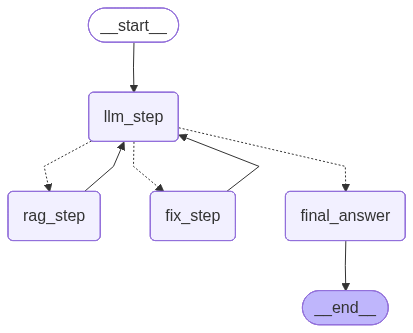

In [283]:
# Создаем Граф
graph = StateGraph(State)

graph.add_node("llm_step", llm_step)
graph.add_node("rag_step", rag_step)
graph.add_node("fix_step", fix_step)
graph.add_node("final_answer", final_answer)

graph.set_entry_point("llm_step")

graph.add_conditional_edges(
    "llm_step",   # узел, после которого роутим
    router_rag_finalanswer,   # функция, возвращающая имя следующего шага
    {
        "rag_step": "rag_step",
        "fix_step": "fix_step",
        "final_answer": "final_answer",
    }
)

graph.add_edge("rag_step", "llm_step")
graph.add_edge("fix_step", "llm_step")
graph.add_edge("final_answer", END)

app = graph.compile()

app

In [284]:
rag_data = ['Первый автомобиль лада выпущен в 2023 году.']

In [285]:
# Инициализируем состояние: RAG уже вернул первые ответы на вопрос пользователя
initial_state = {
    "user_question": "Кем работает Кудла Анастасии?",
    "assistant_question": None,
    "rag_data": ['Кудла Анастатсия это классно', 'Кудла Анастасия по кличке Анастас'],
    "finish": False,
    "raw_output": "",
    "final_answer": None,
    "prompt" : [],
    "valid" : True
}

result = app.invoke(initial_state)

LLM_STEP RAG: ['Кудла Анастатсия это классно', 'Кудла Анастасия по кличке Анастас']
Result: {'user_question': 'Кем работает Кудла Анастасии?', 'rag_data': ['Кудла Анастатсия это классно', 'Кудла Анастасия по кличке Анастас'], 'finish': False, 'assistant_question': 'В какой области или индустрии работает Кудла Анастасия?', 'raw_output': '{"finish": false, "assistant_question": "В какой области или индустрии работает Кудла Анастасия?", "assistant_reasoning": "В предоставленных данных нет информации о профессии или месте работы Кудла Анастасии."}', 'output': {'finish': False, 'assistant_question': 'В какой области или индустрии работает Кудла Анастасия?', 'assistant_reasoning': 'В предоставленных данных нет информации о профессии или месте работы Кудла Анастасии.'}, 'prompt': [SystemMessage(content='Ты — ассистент RAG (Retrieval-Augmented Generation) системы.\n    Твоя цель — определить, хватает ли предоставленных данных (rag_data), чтобы ответить на вопрос пользователя (user_question).\n

In [281]:
print(result['final_answer'])

Кудла Анастасия работает в Антифроде.


# 6. Rag Call (вопрос -> эмбединг -> ответ)

In [98]:
# def answer_generation(question):
#     # Подключаемся к модели
#     client = OpenAI(
#         # Базовый url - сохранять без изменения
#         base_url="https://ai-for-finance-hack.up.railway.app/",
#         # Указываем наш ключ, полученный ранее
#         api_key=LLM_API_KEY,
#     )

#     system_prompt = """Ты RAG-ассистент, вежливый помошник по банковским, финансовым и прочим вопросам. 
#     Пользователь задает тебе вопрос с указанием ответить на него (Ответь на вопрос:). 
#     Так же в сообщении пользователя будет указана информация, которую ты должен использовать для ответа.
#     Отвечай открыто и интересно, по возможности приводи примеры!
#     Начинай с приветсвия пользователя!"""

#     # Формируем запрос к клиенту
#     response = client.chat.completions.create(
#         # Выбираем любую допступную модель из предоставленного списка
#         model="openrouter/google/gemma-3-27b-it",
#         # Формируем сообщение
#         messages=[
            
#                 {"role": "system", "content": system_prompt},
#                 {"role": "user", 
#                 "content": [
#                     {
#                         "type": "text",
#                         "text": f"Ответь на вопрос: {question}"
#                     }
#                 ]}
#         ]
#     )
#     # Формируем ответ на запрос и возвращаем его в результате работы функции
#     return response.choices[0].message.content

In [80]:
def z_logistic(s, k=1.0):
    z = (s - s.mean()) / (s.std(ddof=0) + 1e-9)
    return expit(k * z)

## 6.1 Поулчаем вопрос его эмбединги и осуществляем поиск в faiss

In [61]:
# # Эмбединг вопроса для текста
# example_1024 = get_embedding(text=user_query, dimensions=1024) 
# example_1024 = normalize_vector(example_1024)
# # Эмбединг вопроса для тега + аннотации
# example_512 = get_embedding(text=user_query, dimensions=512) 
# example_512 = normalize_vector(example_512)

In [81]:
# Получаем тестовый вопрос
correct_id = 3 # рандомный идентификатор 
user_query = data.loc[correct_id, 'text'][2][0] # [номер чанка][вопрос, ответ] - выбираем вопрос
print(f'User query: {user_query}')

User query: В чем плюсы и минусы доверительного управления?


In [83]:
# Эмбединг вопроса
example_question = get_embedding(text=user_query) 
example_question = normalize_vector(example_question)

In [85]:
# Топ K вопросов по тексту
top_k_similarities_text, top_k_indices_text = hnsw_index_t.search(np.array([example_question], dtype=np.float32), FAISS_TEXT_K) # В БД Tags+annotation ищем пример

text_sim = dict()
for idx, sim in zip(top_k_indices_text[0], top_k_similarities_text[0]):
    text_sim[idx.item()] = sim.item()

# Ток K вопросам по аннотациям + теги 
top_k_similarities_key_annot, top_k_indices_key_annot = hnsw_index_an_t.search(np.array([example_question], dtype=np.float32), FAISS_ANNOTATION_K) # В БД Tags+annotation ищем пример

tags_annot_sim = dict()
for idx, sim in zip(top_k_indices_key_annot[0], top_k_similarities_key_annot[0]):
    tags_annot_sim[idx.item()] = sim.item()

In [88]:
# Пример
text_sim, tags_annot_sim

({41: -0.7193155288696289,
  42: -0.799937903881073,
  40: -0.908766508102417,
  45: -0.9119541049003601,
  50: -0.913490891456604,
  49: -0.9256871938705444,
  39: -0.9368789196014404,
  34: -0.9575989842414856,
  44: -0.9795986413955688,
  43: -0.9897288084030151,
  35: -1.0312737226486206,
  48: -1.0392636060714722},
 {3: -1.2268404960632324,
  187: -1.308284044265747,
  282: -1.330230474472046,
  304: -1.3590236902236938,
  239: -1.3642051219940186})

## 6.2 TF-IDF

In [90]:
# ---------------------------
# 1) Токенизация
# ---------------------------
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"[a-zа-я0-9]+", text)
    return tokens

# ---------------------------
# 2) Построение индекса
# docs — список строк (документов)
# ---------------------------
class BM25:
    def __init__(self, docs, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.docs = [tokenize(doc) for doc in docs]
        self.N = len(self.docs)

        # длина документа
        self.doc_lengths = [len(doc) for doc in self.docs]
        self.avgDL = sum(self.doc_lengths) / self.N

        # TF-грамматика: list[Counter]
        self.tf = [Counter(doc) for doc in self.docs]

        # DF: количество документов, где встречается слово
        df = defaultdict(int)
        for doc in self.docs:
            for word in set(doc):
                df[word] += 1

        # IDF
        self.idf = {}
        for word, freq in df.items():
            # Okapi IDF с защитой от отрицательности
            self.idf[word] = math.log(1 + (self.N - freq + 0.5) / (freq + 0.5))

    # ---------------------------
    # 3) Счёт BM25 для одного документа
    # ---------------------------
    def score(self, query, index):
        query_tokens = tokenize(query)
        score = 0.0
        doc_tf = self.tf[index]
        doc_len = self.doc_lengths[index]

        for term in query_tokens:
            if term not in doc_tf:
                continue
            tf = doc_tf[term]
            idf = self.idf.get(term, 0)

            denom = tf + self.k1 * (1 - self.b + self.b * doc_len / self.avgDL)
            score += idf * (tf * (self.k1 + 1)) / denom

        return score

    # ---------------------------
    # 4) Поиск top-k
    # ---------------------------
    def search(self, query, top_k=5):
        scores = [(i, self.score(query, i)) for i in range(self.N)]
        scores = sorted(scores, key=lambda x: x[1], reverse=True)
        return scores[:top_k]

# def bm25_screach(query:str, bm25, BM25_TOPK:int = BM25_TOPK):
# 
#     bm25_results = bm25.search(query, top_k=BM25_TOPK)
# 
#     bm25_results = pd.DataFrame(
#         bm25_results,
#         columns=['top_k_indices_text', 'bm25_score']
#         )
#     
#     return bm25_results

In [99]:
# Все наши документы (теги)
docs = list()
for _, val in storage_t.items():
    docs.append(val[1])

bm25 = BM25(docs)

In [100]:
bm25_results = bm25.search(user_query, top_k=BM25_TOPK)

for doc_id, score in bm25_results:
    print(score, docs[doc_id])

bm25_results = pd.DataFrame(
    bm25_results,
    columns=['top_k_indices_text', 'bm25_score']
    )

25.96016087326241 В чем плюсы и минусы доверительного управления?еть от решений посредника, выигрышных или неудачных. Поэтому выбирать доверительного управляющего или ПИФ стоит очень тщательно. Подробнее о рисках, с которыми сталкивается новичок на фондовом рынке, читайте в статье «Что нужно знать начинающему инвестору». В чем особенности ПИФов, по каким критериям выбирать УК и подходящие паи, вы узнаете из статьи «Паевые фонды: как они работают и как на них заработать».
23.981046457947276 В чем плюсы и минусы доверительного управления?Перед тем как обращаться к управляющему или покупать паи ПИФов, важно взвесить все за и против. **Плюсы** * Доверительное управление может принести больше дохода, чем банковский вклад. * Как и в случае с вкладом, вам не нужно постоянно следить за ситуацией на бирже, выбирать ценные бумаги или другие активы, определяться, когда их покупать, а когда продавать. Все решения за вас принимает доверительный управляющий или УК паевого фонда. **Минусы** * Прибыль

## 6.3 Ранжирование чанков и формирования rag_message

__TEXT__

bm25

In [103]:
# Датасет в рамках которого будем крутить скоры
bm25_results['doc_id'] = bm25_results['top_k_indices_text'].apply(lambda idx: storage_t[idx][0])

# Номрализуем косинусную близость - чам больше - тем ближе, т.е. лучше
bm25_results['bm25_score'] = z_logistic(bm25_results[['bm25_score']]) * 0.2

bm25_results

,top_k_indices_text,bm25_score,doc_id
0,42,0.174435,doc_004
1,41,0.163750,doc_004
2,38,0.080991,doc_004
3,3248,0.075911,doc_233
4,37,0.073243,doc_004
5,36,0.070957,doc_004
6,174,0.067966,doc_012
7,3924,0.064544,doc_283


Embedings

In [104]:
# Датасет в рамках которого будем крутить скоры
df_text_result = pd.DataFrame({
    'top_k_indices_text' : top_k_indices_text[0].T,
    'cos_scores' : top_k_similarities_text[0].T,
    'doc_id' : [storage_t[idx.item()][0] for idx in top_k_indices_text[0]]
    })

# Номрализуем косинусную близость - чам больше - тем ближе, т.е. лучше
df_text_result['cos_scores_m'] = z_logistic(df_text_result[['cos_scores']]) 
# Взвешиваем скор
df_text_result['cos_scores_m'] = df_text_result['cos_scores_m'] * 0.65

# номер чанка (бж текст), косинусная близость, документ, нормированная косинусная близость
df_text_result

,top_k_indices_text,cos_scores,doc_id,cos_scores_m
0,41,-0.719316,doc_004,0.594532
1,42,-0.799938,doc_004,0.526226
2,40,-0.908767,doc_004,0.357245
3,45,-0.911954,doc_004,0.351353
4,50,-0.913491,doc_004,0.348505
5,49,-0.925687,doc_004,0.325815
6,39,-0.936879,doc_004,0.304982
7,34,-0.957599,doc_004,0.266968
8,44,-0.979599,doc_004,0.228348
9,43,-0.989729,doc_004,0.211448


__Annotation, Tags__

In [105]:
df_tags_annot_result = pd.DataFrame({
    'top_k_indices_key_annot' : top_k_indices_key_annot[0].T,
    'cos_scores_ka' : top_k_similarities_key_annot[0].T,
    'doc_id' : [storage_an_t[idx.item()][0] for idx in top_k_indices_key_annot[0]]
    })

# Могут быть дубли, на 1 документ 2 чанка - возьмем наиближайшего соседа
df_tags_annot_result_agg = df_tags_annot_result.groupby('doc_id')['cos_scores_ka'].min().reset_index()
# Номрализуем косинусную близость - чам больше - тем ближе, т.е. лучше
df_tags_annot_result_agg['cos_scores_ka_m'] = z_logistic(df_tags_annot_result_agg['cos_scores_ka'])
# Взвешиваем скор
df_tags_annot_result_agg['cos_scores_ka_m'] = df_tags_annot_result_agg['cos_scores_ka_m'] * 0.15

# Документ, косинусная близость, нормированная косинусная близость
df_tags_annot_result_agg

,doc_id,cos_scores_ka,cos_scores_ka_m
0,doc_004,-1.226840,0.129210
1,doc_184,-1.308284,0.082090
2,doc_230,-1.364205,0.042299
3,doc_269,-1.330230,0.065616
4,doc_290,-1.359024,0.045533


__Prepare rag context__

In [109]:
# Холдер для аннотации
annotation_doc_id = ''

# Соберем единый датасет
df_for_sort = df_text_result.merge(
        df_tags_annot_result_agg, 
        on='doc_id', 
        how='outer'
    ).merge(
        bm25_results, 
        on=['top_k_indices_text', 'doc_id'], 
        how='outer'        
    )

# Заполним пропуски в скорах
df_for_sort['cos_scores_m'] = df_for_sort['cos_scores_m'].fillna(0)
df_for_sort['cos_scores_ka_m'] = df_for_sort['cos_scores_ka_m'].fillna(0)
df_for_sort['bm25_score'] = df_for_sort['bm25_score'].fillna(0)

# Единый скор и сортировка, оставляем топ SK чанков
df_for_sort['result_score'] = df_for_sort['cos_scores_m'] + df_for_sort['cos_scores_ka_m'] + df_for_sort['bm25_score'] 
df_for_sort = df_for_sort.sort_values('result_score', ascending=False)
target_text_chunk = df_for_sort.reset_index(drop=True).loc[:TOP_K-1, ['top_k_indices_text', 'doc_id']]

# NEW - индексы для чанков по тексту
target_text_chunk_notna = target_text_chunk[~target_text_chunk['top_k_indices_text'].isna()]

# # Собираем чанки текста из storage_t
message_for_rerank = [storage_t[key][1] for key in target_text_chunk_notna['top_k_indices_text']]
# rag_message = '\n'.join(rag_message)

# # Если есть doc_id без чанка, добавим анотацию doc_id 
if (target_text_chunk['top_k_indices_text'].isna()).any(): 
    # Получаем doc_id у пропущенного значения 
    annotation_doc_id = target_text_chunk[
        target_text_chunk['top_k_indices_text'].isna()
        ].reset_index()\
        .loc[0, 'doc_id'] 
    
    annotation_missed_chunk = data[data['id']==annotation_doc_id]['annotation'].values[0] # Аннотация пропущенного id
    message_for_rerank.append(f"\nАннотация: {annotation_missed_chunk}")

# Добавим анатацию самого сонаправленного doc_id
if annotation_doc_id != target_text_chunk.loc[0, 'doc_id']:
    annotation_doc_id = target_text_chunk.loc[0, 'doc_id']
    annotation_top1 = data[data['id']==annotation_doc_id]['annotation'].values[0] # Аннотация пропущенного id
    message_for_rerank.append(f"\nАннотация: {annotation_top1}")

target_text_chunk


,top_k_indices_text,doc_id
0,41.0,doc_004
1,42.0,doc_004
2,40.0,doc_004
3,45.0,doc_004
4,50.0,doc_004
5,49.0,doc_004
6,39.0,doc_004
7,34.0,doc_004
8,44.0,doc_004
9,43.0,doc_004


In [131]:
message_for_rerank

['В чем плюсы и минусы доверительного управления?Перед тем как обращаться к управляющему или покупать паи ПИФов, важно взвесить все за и против. **Плюсы** * Доверительное управление может принести больше дохода, чем банковский вклад. * Как и в случае с вкладом, вам не нужно постоянно следить за ситуацией на бирже, выбирать ценные бумаги или другие активы, определяться, когда их покупать, а когда продавать. Все решения за вас принимает доверительный управляющий или УК паевого фонда. **Минусы** * Прибыль не гарантирована. Инвестиции — это всегда риск, и чем больше потенциальная доходность, тем выше вероятность все потерять. Деньги в доверительном управлении не защищены государственной системой страхования вкладов. * Ваши доходы будут зависеть от решений посредника, выигрышных или неудачных. Поэтому выбирать доверительного управляющего или ПИФ стоит очень тщательно. Подробнее о рисках, с которыми сталкивается новичок на фондовом рынке, читайте в статье «Что нужно знать нач',
 'В чем плюсы

## 6.4 Reranker

In [289]:
import requests

In [304]:
RERANKER_BEARER_KEY = "HTTPBearer-959y"

query = "What is the capital of Russia?"
documents = [
                "Mumrans is the biggest city at the north pole.",
                "Monaco is capital town!",
                "Moscow."
            ]

In [306]:
def rerank_docs(query, documents, bearer_key):
    url = 'https://custom-servers.t1v.scibox.tech/jnserver/564/application/rerank'

    # Формируем заголовок для запроса
    headers = {
        # Указываем тип получаемого контента
        "Content-Type": "application/json",
        # Указываем наш ключ, полученный ранее
        "Authorization": f"Bearer {bearer_key}"
    }

    response = requests.post(
        url = url,
        headers=headers,
        json={
            "query" : query,
            "documents" : documents
        }
    )

    return response.json()


def reranker(user_query: str, message_for_rerank: List[str]):
    result_metrics = rerank_docs(
        query=user_query,
        documents=message_for_rerank,
        bearer_key=RERANKER_BEARER_KEY
    )

    final_sort = pd.DataFrame({
        'score' : result_metrics, 
        'text' : message_for_rerank
    }).sort_values('score', ascending=False)\
    .reset_index(drop=True)

    rag_message = '\n'.join([x for x in final_sort.loc[:KLLM-1, 'text']])

    rag_text_for_llm = f'\n**Для ответа используй следующие знания из RAG базы данных**:\n{rag_message}'

    return rag_text_for_llm

user_query="В чем минусы и плюсы доверительного управления?"

rag_text_for_llm = reranker(message_for_rerank=message_for_rerank, user_query=user_query)

print(rag_text_for_llm)


**Для ответа используй следующие знания из RAG базы данных**:
Какие виды доверительного управления бывают на финансовом рынке?ентов. Инвесторы, которые выбрали какую-то стандартную стратегию раньше, могут продолжать ей пользоваться — но только до конца договора о присоединении к этой стратегии. **Индивидуальные стратегии доверительного управления**. В этом случае доверительный управляющий разрабатывает для каждого клиента персональную стратегию. Она учитывает сумму и срок вложений, доходность, которую инвестор ожидает получить, и допустимый для него уровень потерь. Управляющие принимают в расчет и другие факторы — доход, возраст, образование человека, его опыт на финансовом рынке. Важно, сколько он уже инвестировал в другие активы и какие у него расходы — например, на выплату алиментов или погашение кредитов. Индивидуальный подход позволяет управляющему правильно оценить, к какому риску клиент готов в действительности, и подобрать стратегию, которая не подорвет финансовое положение и 

In [308]:
result_metrics = rerank_docs(
    query="В чем минусы и плюсы доверительного управления?",
    documents=message_for_rerank,
    bearer_key=RERANKER_BEARER_KEY
)

result_metrics

[1.279494047164917,
 -1.4478482007980347,
 -2.4864413738250732,
 -1.8744491338729858,
 -0.48811519145965576,
 -0.7013200521469116,
 4.492132186889648,
 -2.1040799617767334,
 -1.4086263179779053,
 2.516270637512207,
 2.81085467338562,
 0.8934906721115112,
 -1.879413366317749]

## 6.5 Единый пайплайн

In [133]:
user_query = 'В чем плюсы и минусы доверительного управления?'

In [135]:
def rag_search(user_query:str) -> Tuple:
    '''RAG поиск документов в FAISS (Косинусная близость) и BM25 (Статистическое сходство)'''
    ####### FAISS (Косинусная близость)
    # Эмбединг вопроса
    embed_user_question = get_embedding(text=user_query) 
    embed_user_question = normalize_vector(embed_user_question)

    # Топ K чанков по тексту
    top_k_similarities_text, top_k_indices_text = hnsw_index_t.search(
        np.array([embed_user_question], dtype=np.float32), 
        FAISS_TEXT_K
        )

    text_sim = dict()
    for idx, sim in zip(top_k_indices_text[0], top_k_similarities_text[0]):
        text_sim[idx.item()] = sim.item()

    # Ток K чанков по аннотациям + теги 
    top_k_similarities_key_annot, top_k_indices_key_annot = hnsw_index_an_t.search(
        np.array([embed_user_question], dtype=np.float32), 
        FAISS_ANNOTATION_K
        )

    tags_annot_sim = dict()
    for idx, sim in zip(top_k_indices_key_annot[0], top_k_similarities_key_annot[0]):
        tags_annot_sim[idx.item()] = sim.item()

    ####### BM25 (Статистическое сходство)
    bm25_results = bm25.search(user_query, top_k=BM25_TOPK)

    bm25_results = pd.DataFrame(
        bm25_results,
        columns=['top_k_indices_text', 'bm25_score']
        )
    
    return bm25_results, top_k_similarities_text, top_k_indices_text, top_k_similarities_key_annot, top_k_indices_key_annot

In [137]:
def rag_prepare_txt2llm(
        bm25_results,
        top_k_similarities_text,
        top_k_indices_text,
        top_k_similarities_key_annot,
        top_k_indices_key_annot,
        storage_t,
        storage_an_t
    ):
    '''Формирование чанков текста из трех источников для последующего ранжирования'''
    ####### Подготавливаем идеентичные датасеты из трех источников

    #### 1. BM25
    # Датасет в рамках которого будем крутить скоры
    bm25_results['doc_id'] = bm25_results['top_k_indices_text'].apply(lambda idx: storage_t[idx][0])
    # Номрализуем косинусную близость - чам больше - тем ближе, т.е. лучше
    bm25_results['bm25_score'] = z_logistic(bm25_results[['bm25_score']]) * BM25_WEIGHT

    #### 2. Faiss Текст 
    # Собираем doc_id
    df_text_result = pd.DataFrame({
        'top_k_indices_text' : top_k_indices_text[0].T,
        'cos_scores' : top_k_similarities_text[0].T,
        'doc_id' : [storage_t[idx.item()][0] for idx in top_k_indices_text[0]]
        })
    # Номрализуем косинусную близость - чам больше - тем ближе, т.е. лучше
    df_text_result['cos_scores_m'] = z_logistic(df_text_result[['cos_scores']]) 
    # Взвешиваем скор
    df_text_result['cos_scores_m'] = df_text_result['cos_scores_m'] * FAISS_TEXT

    #### 3. Faiss Аннотация и теги 
    df_tags_annot_result = pd.DataFrame({
        'top_k_indices_key_annot' : top_k_indices_key_annot[0].T,
        'cos_scores_ka' : top_k_similarities_key_annot[0].T,
        'doc_id' : [storage_an_t[idx.item()][0] for idx in top_k_indices_key_annot[0]]
        })
    # Могут быть дубли, на 1 документ 2 чанка - возьмем наиближайшего соседа
    df_tags_annot_result_agg = df_tags_annot_result.groupby('doc_id')['cos_scores_ka'].min().reset_index()
    # Номрализуем косинусную близость - чам больше - тем ближе, т.е. лучше
    df_tags_annot_result_agg['cos_scores_ka_m'] = z_logistic(df_tags_annot_result_agg['cos_scores_ka'])
    # Взвешиваем скор
    df_tags_annot_result_agg['cos_scores_ka_m'] = df_tags_annot_result_agg['cos_scores_ka_m'] * FAISS_TAGS_ANNOT

    ####### Подготовка чанков
    # Холдер для аннотации
    annotation_doc_id = ''

    # Соберем единый датасет
    df_for_sort = df_text_result.merge(
            df_tags_annot_result_agg, 
            on='doc_id', 
            how='outer'
        ).merge(
            bm25_results, 
            on=['top_k_indices_text', 'doc_id'], 
            how='outer'        
        )

    # Заполним пропуски в скорах, если чанк не оказался релевантным
    df_for_sort['cos_scores_m'] = df_for_sort['cos_scores_m'].fillna(0)
    df_for_sort['cos_scores_ka_m'] = df_for_sort['cos_scores_ka_m'].fillna(0)
    df_for_sort['bm25_score'] = df_for_sort['bm25_score'].fillna(0)

    # Единый скор и сортировка, оставляем топ SK чанков
    df_for_sort['result_score'] = df_for_sort['cos_scores_m'] + df_for_sort['cos_scores_ka_m'] + df_for_sort['bm25_score'] 
    df_for_sort = df_for_sort.sort_values('result_score', ascending=False)
    target_text_chunk = df_for_sort.reset_index(drop=True).loc[:TOP_K-1, ['top_k_indices_text', 'doc_id']]

    # Индексы для чанков по тексту
    target_text_chunk_notna = target_text_chunk[~target_text_chunk['top_k_indices_text'].isna()]

    # # Собираем чанки текста из storage_t
    message_for_rerank = [storage_t[key][1] for key in target_text_chunk_notna['top_k_indices_text']]

    # Если есть doc_id без чанка, добавим анотацию doc_id 
    if (target_text_chunk['top_k_indices_text'].isna()).any(): 
        # Получаем doc_id у пропущенного значения 
        annotation_doc_id = target_text_chunk[
            target_text_chunk['top_k_indices_text'].isna()
            ].reset_index()\
            .loc[0, 'doc_id'] 
        
        annotation_missed_chunk = data[data['id']==annotation_doc_id]['annotation'].values[0] # Аннотация пропущенного id
        message_for_rerank.append(f"\nАннотация: {annotation_missed_chunk}")

    # Добавим анатацию самого сонаправленного doc_id
    if annotation_doc_id != target_text_chunk.loc[0, 'doc_id']:
        annotation_doc_id = target_text_chunk.loc[0, 'doc_id']
        annotation_top1 = data[data['id']==annotation_doc_id]['annotation'].values[0] # Аннотация пропущенного id
        message_for_rerank.append(f"\nАннотация: {annotation_top1}")

    return message_for_rerank

In [337]:
def rag(user_query):

        # Собираем голосование релевантности из 3х источников
        bm25_results, top_k_similarities_text, top_k_indices_text,\
                top_k_similarities_key_annot, top_k_indices_key_annot = rag_search(user_query)

        # Подготоавливаем чанки текста для рандирования
        message_for_rerank = rag_prepare_txt2llm(
                bm25_results=bm25_results, 
                top_k_similarities_text=top_k_similarities_text, 
                top_k_indices_text=top_k_indices_text, 
                top_k_similarities_key_annot=top_k_similarities_key_annot, 
                top_k_indices_key_annot=top_k_indices_key_annot,
                storage_t=storage_t,
                storage_an_t=storage_an_t
        )

        # Получаем RAG контекст (с топ релевантными чанками)
        rag_answer = reranker(user_query, message_for_rerank)

        return rag_answer

# 7. Агент

In [338]:
from typing import TypedDict, List, Optional, Any
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

In [339]:
# =========================
# 1. State
# =========================

class RagChunk(TypedDict):
    text: str
    source: Optional[str]
    query: Optional[str]
    score: Optional[float]

class State(TypedDict):
    user_question: str
    rag_data: List[str] # RagChunk

    # decision results
    sufficient: bool
    followup_query: Optional[str]
    confidence: float

    # control
    iteration: int
    max_iterations: int

    # final output
    final_answer: Optional[str]

In [340]:
# =========================
# 2. Tool (function calling)
# =========================

@tool
def judge_rag_sufficiency(
    sufficient: bool,
    followup_query: Optional[str] = None,
    confidence: float = 0.0
):
    """
    Реши, является ли предоставленный контекст RAG достаточным для ответа на вопрос пользователя.

    Если контекста не хватает:
      - sufficient = False
      - followup_query должен быть конкретный поисковый запрос для базы данных

    Если контекста хватает:
      - sufficient = True
      - followup_query должно быть Null
    """
    return {
        "sufficient": sufficient,
        "followup_query": followup_query,
        "confidence": confidence,
    }

In [341]:
# =========================
# 3. LLM (bound to tool)
# =========================

llm = ChatOpenAI(
    model="google/gemini-2.5-flash-lite",
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0,
    api_key=OPENROUTER_API_KEY
).bind_tools([judge_rag_sufficiency])

In [359]:
# =========================
# 4. Nodes
# =========================

def judge_step(state: State) -> State:
    """
    LLM определяет, достаточно ли текущих данных RAG.
    НЕОБХОДИМО вызвать инструмент judge_rag_sufficiency.
    """

    # context_text = "\n\n".join(
    #     f"[source={c['source']}] {c['text']}"
    #     for c in state["rag_data"]
    # )

    context_text = "\n\n".join(
        f"{c}"
        for c in state["rag_data"]
    )

    system_prompt = """
Ты — агент принятия решений RAG-системы.

Твоя задача:
- оценить, достаточно ли контекста, чтобы ответить на вопрос пользователя
- если недостаточно — сформулировать ОДИН точный поисковый запрос для БД

⚠️ **Ты ОБЯЗАН вызвать функцию judge_rag_sufficiency**!
⚠️ **Действуй согласно инструкции!**.
⚠️ **Не отвечай текстом!**
"""
    print('----', 'judge_step')
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"""
Вопрос пользователя:
{state['user_question']}

Контекст:
{context_text}
""")
    ]

    # LLM выберет инструмент и заполнит его аргументы
    result = llm.invoke(messages) 
    print("result.tool_calls:", result.tool_calls)

    if not result.tool_calls:
        print('fallback: LLM не смог оценить')
        state["sufficient"] = False
        state["followup_query"] = state["user_question"]
        state["confidence"] = 0.0
        return state

    tool_call = result.tool_calls[0]
    args = tool_call["args"]

    state["sufficient"] = args["sufficient"]
    state["followup_query"] = args.get("followup_query")
    state["confidence"] = args.get("confidence", 0.0)

    return state


def first_call_rag(state: State) -> State:
    """
    Retrieve new documents using followup_query
    """
    print('----', 'first_call_rag')

    query = state["user_question"]

    rag_answer = rag(query)

    state["rag_data"].append(rag_answer)
    state["iteration"] += 1
    print(state)

    return state

def rag_step(state: State) -> State:
    """
    Retrieve new documents using followup_query
    """
    print('----', 'rag_step')

    if state['iteration'] > 0:
        query = state["followup_query"]
    else:
        query = state["user_question"]

    # 🔧 RAG 
    rag_answer = rag(query)

    cur_chunk = {
        "text": rag_answer,
        "source": "rag_step",
        "query": query,
        "score": 1.0
    }

    state["rag_data"].append(cur_chunk)
    state["iteration"] += 1

    return state


def final_answer_step(state: State) -> State:
    """
    Final answering LLM
    """
    print('----', 'final_answer_step')

    # context_text = "\n\n".join(
    #     c["text"] for c in state["rag_data"]
    # )

    context_text = "\n\n".join(
        f"{c}"
        for c in state["rag_data"]
    )

    prompt = [
        SystemMessage(content="""
Ты — помощник.
Ответь на вопрос пользователя, используя ТОЛЬКО предоставленный контекст.
Не выдумывай факты.
"""),
        HumanMessage(content=f"""
Вопрос:
{state['user_question']}

Контекст:
{context_text}
""")
    ]

    answer = ChatOpenAI(
        model="qwen/qwen3-32b",
        openai_api_base="https://openrouter.ai/api/v1",
        temperature=0,
        api_key=OPENROUTER_API_KEY
    ).invoke(prompt)

    state["final_answer"] = answer.content
    return state

In [360]:
# =========================
# 5. Router
# =========================

def router(state: State) -> str:
    print('----', 'router')
    if state["sufficient"]:
        return "final_answer"

    if state["iteration"] >= state["max_iterations"]:
        return "final_answer"

    return "rag_step"

In [361]:
# =========================
# 6. Graph
# =========================

graph = StateGraph(State)


graph.add_node("first_call_rag", first_call_rag)
graph.add_node("judge", judge_step)
graph.add_node("rag_step", rag_step)
graph.add_node("final_answer", final_answer_step)

graph.set_entry_point("first_call_rag")

graph.add_edge("first_call_rag", "judge")

graph.add_conditional_edges(
    "judge",
    router,
    {
        "rag_step": "rag_step",
        "final_answer": "final_answer",
    }
)

graph.add_edge("rag_step", "judge")
graph.add_edge("final_answer", END)

app = graph.compile()

In [362]:
from IPython.display import Image, display

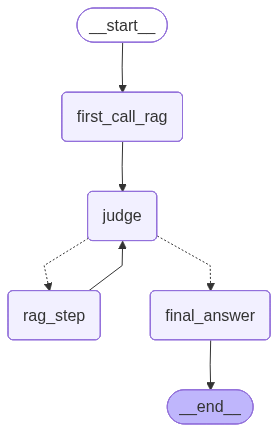

In [363]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [348]:
# -------------------------
# 1. Создаём initial state
# -------------------------
initial_state = {
    "user_question": "Какие налоги уплачиваются с вклада?",
    "rag_data": [],
    "sufficient": False,
    "followup_query": None,
    "confidence": 0.0,
    "iteration": 0,
    "max_iterations": 3,
    "final_answer": None,
}
# -------------------------
# 2. Запускаем graph
# -------------------------
state = app.invoke(initial_state)
# -------------------------
# 3. Проверяем результат
# -------------------------
print("Финальное состояние агента:")
print(state)
print('Assistant: ', state['final_answer'], sep='\n\n')

---- first_call_rag
{'user_question': 'Какие налоги уплачиваются с вклада?', 'rag_data': ['\n**Для ответа используй следующие знания из RAG базы данных**:\nКакие условия у социального вклада?**Сумма социального вклада** не должна превышать 50 000 рублей. Вы можете положить на депозит меньшую сумму, а затем пополнять его, пока размер вклада не достигнет лимита. **Ставка**. Банк установит самый высокий процент из тех, что предлагает по депозитам сроком от месяца до года. Ставка не фиксированная. Она может меняться в течение действия договора, но всегда будет максимальной в этом банке. Если ставка изменится, вам придет уведомление об изменении условий. Проценты по вкладу перечисляются ежемесячно на любой счет, который вы укажете при заключении договора. То есть их можно будет тратить, даже не дожидаясь окончания депозита. **Срок вклада** – год. По истечении договора банк снова проверит, полагается ли вам соцвклад. Если да – договор автоматически пролонгируется. Потеряете право на льготы —

In [358]:
# -------------------------
# 1. Создаём initial state
# -------------------------
initial_state = {
    "user_question": "Какие налоги уплачиваются с вклада?",
    "rag_data": [],
    "sufficient": False,
    "followup_query": None,
    "confidence": 0.0,
    "iteration": 0,
    "max_iterations": 3,
    "final_answer": None,
}
# -------------------------
# 2. Запускаем graph
# -------------------------
state = app.invoke(initial_state)
# -------------------------
# 3. Проверяем результат
# -------------------------
print("Финальное состояние агента:")
print(state)
print('Assistant: ', state['final_answer'], sep='\n\n')

---- first_call_rag
{'user_question': 'Какие налоги уплачиваются с вклада?', 'rag_data': ['\n**Для ответа используй следующие знания из RAG базы данных**:\nКакие условия у социального вклада?**Сумма социального вклада** не должна превышать 50 000 рублей. Вы можете положить на депозит меньшую сумму, а затем пополнять его, пока размер вклада не достигнет лимита. **Ставка**. Банк установит самый высокий процент из тех, что предлагает по депозитам сроком от месяца до года. Ставка не фиксированная. Она может меняться в течение действия договора, но всегда будет максимальной в этом банке. Если ставка изменится, вам придет уведомление об изменении условий. Проценты по вкладу перечисляются ежемесячно на любой счет, который вы укажете при заключении договора. То есть их можно будет тратить, даже не дожидаясь окончания депозита. **Срок вклада** – год. По истечении договора банк снова проверит, полагается ли вам соцвклад. Если да – договор автоматически пролонгируется. Потеряете право на льготы —

In [364]:
# -------------------------
# 1. Создаём initial state
# -------------------------
initial_state = {
    "user_question": "Какой налог уплачивается с договора ГПХ?",
    "rag_data": [],
    "sufficient": False,
    "followup_query": None,
    "confidence": 0.0,
    "iteration": 0,
    "max_iterations": 3,
    "final_answer": None,
}
# -------------------------
# 2. Запускаем graph
# -------------------------
state = app.invoke(initial_state)
# -------------------------
# 3. Проверяем результат
# -------------------------
print("Финальное состояние агента:")
print(state)
print("Финальное состояние агента:")
print(state)
print('Assistant: ', state['final_answer'], sep='\n\n')

---- first_call_rag
{'user_question': 'Какой налог уплачивается с договора ГПХ?', 'rag_data': ['\n**Для ответа используй следующие знания из RAG базы данных**:\nКак получить вычет с дохода от продажи имущества?13% налога только с разницы. Если имущество подешевело, налога вообще не будет, так как не возникло дохода. Но вам придется подать декларацию и подтвердить снижение цены: договорами, чеками или квитанциями, оставшимися от сделок. Иначе вы рискуете получить штраф из налоговой. Иногда, помимо цены покупки, разрешается вычесть из стоимости продажи и другие траты. Например, вы вложились в квартиру без отделки, сделали в ней дорогой ремонт и через год продаете. В этом случае свои расходы можно будет подтвердить не только договором купли-продажи самого жилья, но и чеками на стройматериалы, договорами об оплате работ. Игорь купил первую квартиру за 1,5 млн ₽, а через три года продал ее за 2 млн ₽. С дохода он должен был заплатить НДФЛ. С учетом вычета на продажу жилья ему пришлось бы пе

In [365]:
# -------------------------
# 1. Создаём initial state
# -------------------------
initial_state = {
    "user_question": "Что такое ИИС?",
    "rag_data": [],
    "sufficient": False,
    "followup_query": None,
    "confidence": 0.0,
    "iteration": 0,
    "max_iterations": 3,
    "final_answer": None,
}
# -------------------------
# 2. Запускаем graph
# -------------------------
state = app.invoke(initial_state)
# -------------------------
# 3. Проверяем результат
# -------------------------
print("Финальное состояние агента:")
print(state)
print("Финальное состояние агента:")
print(state)
print('Assistant: ', state['final_answer'], sep='\n\n')

---- first_call_rag
{'user_question': 'Что такое ИИС?', 'rag_data': ['\n**Для ответа используй следующие знания из RAG базы данных**:\nЧто важно знать про ИСЖ?Прежде чем оформлять полис ИСЖ, стоит учесть несколько важных особенностей, которые сильно отличают его от других финансовых инструментов, особенно от вкладов. **1. Вложения в ИСЖ не входят в****систему страхования вкладов****.** Если страховщик обанкротится, вы можете потерять внесенные деньги частично или полностью. Как действовать, чтобы повысить свои шансы вернуть вложения, можно прочитать в материале «У моей страховой компании отозвали лицензию: что делать». **2. Нет гарантии дополнительного дохода.** В отличие от банковских вкладов, процент по которым известен заранее, доход по ИСЖ непредсказуем. Например, люди, у которых полисы закончились в I квартале 2019 года, в среднем получили меньше 3% годовых по своим вложениям. С 1 апреля 2024 года Банк России установил размер минимальных выплат для полисов дешевле 1,5 млн рублей, 